In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [2]:
import pickle
import json

In [3]:
def plot_gr(gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    plt.figure(figsize=(s,s))
    if end == -1:
        end = gr.shape[0]
    if log:
        plt.imshow(np.log(gr[start:end,start:end] + 1))
    else:
        plt.imshow(gr[start:end,start:end])
    plt.colorbar()
    if all_ticks: 
        plt.xticks(np.arange(start,end))
        plt.yticks(np.arange(start,end))
    plt.show()

In [6]:
gr_tr = np.load("../../data/graphs/ES3_22.npy")
nd = pickle.load(open("../../data/dicts/ES3_nd", 'rb'))
cl_to_n = pickle.load(open("../../data/dicts/ES3_cl_to_n", 'rb'))

In [12]:
values = []
for k,v in nd.items():
    print(cl_to_n[k], v)
    values.append(v)

0 28374
1 20414
2 14353
3 13974
4 11315
5 8389
6 7672
7 6864
8 6274
9 4979
10 3798
11 3740
12 3707
13 2920
14 2764
15 2611
16 2390
17 1913
18 436
19 331
20 329
21 195
22 192
23 173
24 163
25 158
26 129
27 123
28 109
29 92
30 89
31 87
32 68
33 56
34 17
35 5
36 3
37 2
38 2
39 2
40 2
41 1
42 1
43 2
44 1
45 2
46 1
47 1
48 1
49 1
50 1
51 1
52 4
53 1
54 1
55 1
56 1
57 1
58 1
59 2
60 1
61 3
62 1
63 1
64 1
65 1
66 1
67 2
68 1
69 1
70 1
71 1


In [17]:
values[:17]

[28374,
 20414,
 14353,
 13974,
 11315,
 8389,
 7672,
 6864,
 6274,
 4979,
 3798,
 3740,
 3707,
 2920,
 2764,
 2611,
 2390]

In [ ]:
[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11]

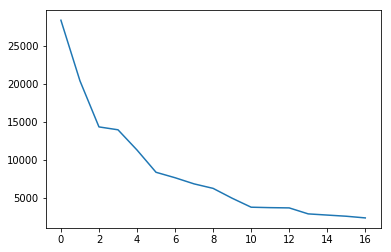

In [16]:
plt.plot(values[:17])
plt.show()

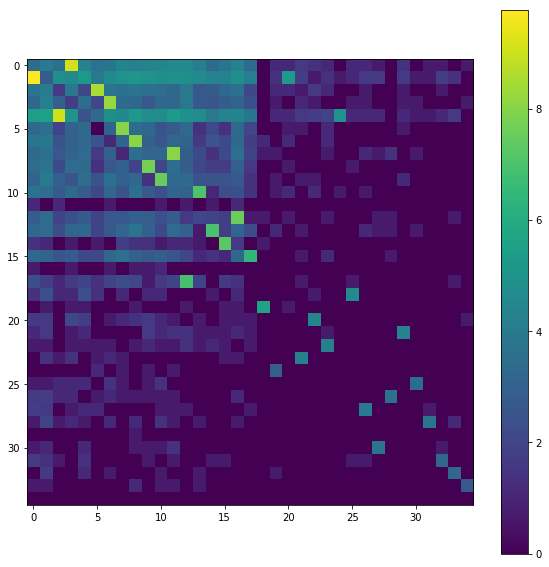

In [15]:
plot_gr(gr_tr[:35,:35], log=1)

In [18]:
from nltk import ngrams

In [19]:
np.random.binomial(1, 0.5, 10)

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [20]:
SWITCH_PROB = 0.2
AMPLIFY_PROB = 1.
STOP_PROB = 0
MAX_LEN = 5

In [21]:
MAX_LEN = 6
population = np.ones((3,MAX_LEN + 1)) * -1
population[0,0:6] = np.arange(0,6)
population[0,0] = 0
population[1,0:6] = np.arange(6,12)
population[1,0] = 1
population[2,0:6] = np.arange(12,18)
population[2,0] = 2
population

array([[ 0.,  1.,  2.,  3.,  4.,  5., -1.],
       [ 1.,  7.,  8.,  9., 10., 11., -1.],
       [ 2., 13., 14., 15., 16., 17., -1.]])

In [22]:
population_f = population.copy()
population_b = reverse_population(population_f)

NameError: name 'reverse_population' is not defined

In [23]:
single_amplify(population_f, np.ones(3), 1,1)

NameError: name 'single_amplify' is not defined

In [24]:
population_f

array([[ 0.,  1.,  2.,  3.,  4.,  5., -1.],
       [ 1.,  7.,  8.,  9., 10., 11., -1.],
       [ 2., 13., 14., 15., 16., 17., -1.]])

In [25]:
population_b

NameError: name 'population_b' is not defined

In [26]:
population_f, population_b = PCR_cycle(population_f, population_b, np.array([1,1,1]))

NameError: name 'PCR_cycle' is not defined

In [27]:
def reverse_population(p):
    p_b = p.copy()
    for i in range(p.shape[0]):
        length = (p[i] != -1).sum() - 1
        
        p_b[i,1:length + 1] = p[i,1:length + 1][::-1]
    return p_b

In [28]:
def PCR_cycle(population_f, population_b, switch_weights):       
    new_f = single_amplify(population_f, switch_weights, reverse=0)
    #new_b = single_amplify(population_f, switch_weights)
    
    population_f = np.vstack((population_f, new_f))
    #population_b = np.vstack((population_b, new_b))
    
    return population_f, population_b

In [29]:
def generate_initial_population(spacers_num, chain_number=2, max_amount_per_chain = 2, min_len = 4, v = False):
    # markov is our god! 
    graph = np.zeros((spacers_num, spacers_num))
    for i in range(spacers_num):
        for j in range(spacers_num -1, i, -1):
            graph[i,j] = spacers_num - j

    if v:
        plot_gr(graph)
        
    graph /= np.max(np.vstack((graph.sum(1), np.ones(spacers_num))), 0).reshape(-1,1)
    all_chains = []
    while len(all_chains) < chain_number:
        chain = []
        amount = np.random.randint(1, max_amount_per_chain)
        max_len = max([np.random.randint(min_len,spacers_num + 1) for i in range(3)])
        curr = np.random.randint(0, (spacers_num - 1) / 2 )

        for j in range(max_len):
            chain.append(curr)
            if curr != spacers_num - 1:
                #print(np.arange(spacers_num), graph[curr])
                curr = np.random.choice(np.arange(spacers_num), 1, p = graph[curr])[0]
            else:
                break
        
        if len(chain) > min_len:
            all_chains.extend([chain for k in range(amount)])
    
    return all_chains[:chain_number]

In [30]:
def population_from_list_of_lists(list_of_lists, cassettes_types = None, multiplier = 1):
    max_len = max([len(x) for x in list_of_lists])
    population_f = np.ones((len(list_of_lists), max_len + 1)) * (-1)
    population_b = np.ones((len(list_of_lists), max_len + 1)) * (-1)
    for i,l in enumerate(list_of_lists):
        population_f[i, 1:len(l) + 1] = np.array(l)
        population_b[i, 1:len(l) + 1] = np.array(l[::-1])
        
    if cassettes_types is not None:
        population_f[:,0],population_b[:,0] = [np.array(cassettes_types)]*2
        
    else:
        population_f[:,0],population_b[:,0] = [0]*2
    
    if multiplier > 1:
        population_f = np.vstack([population_f] * multiplier)
        population_b = np.vstack([population_b] * multiplier)
    return population_f, population_b, max_len
        

In [31]:
population_as_list = [[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(5)] + \
               [[4, 2, 5, 7, 11] for i in range(5)] + \
               [[24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34]] + \
               [[20, 22, 23, 21, 29]]

pairs_1 = set([x for y in population_as_list[:10] for x in ngrams(y, 2)])
pairs_2 = set([x for y in population_as_list[10:] for x in ngrams(y, 2)])

In [32]:
all_ratios_plots = []

In [33]:
np.random.randint(1,3,10)

array([2, 1, 1, 2, 1, 2, 2, 2, 2, 1])

In [34]:
def single_amplify(all_population, switch_weights, reverse = True, v = False): 
    mask = np.random.binomial(1, AMPLIFY_PROB, all_population.shape[0]).astype(bool)
    population_to_amplify = all_population[mask] 
    new = np.ones((population_to_amplify.shape[0], MAX_LEN + 1)) * (-1)
    
    if v:
        print(mask)
        print(population_to_amplify)
    
    i = 0
    for chain in population_to_amplify:
        source_len = (chain != -1).sum() - 1 
        to_start = False
        start = 0
        while not to_start and start < source_len:
            start += 1
            if np.random.random() < START_PROB:
                to_start = True
        if v: print("start : ", start)
            
        #start = np.random.randint(1, source_len + 1 - 1)
        stop = False
#        end = np.random.randint(start + 1, source_len + 1)
        
        
        pointer_new = 1
        pointer_source = start
        
        new[i,0] = chain[0]
        
        while not stop:            
            new[i,pointer_new] = chain[pointer_source]
            
            pointer_new += 1
            pointer_source += 1
            
            switch = np.random.rand() < SWITCH_PROB
            
            if v:
                print(chain, new[i], switch)
            if switch:
                mask = np.zeros(1)
                while mask.sum() ==0:
                    chain_type = np.random.choice(np.arange(switch_weights.shape[0]), p = switch_weights / switch_weights.sum())
                    mask = population_to_amplify[:, 0] == chain_type

                chain = population_to_amplify[mask][np.random.randint(0, mask.sum())]
                source_len = (chain != -1).sum() - 1 
                pointer_source = np.random.randint(1, source_len)

            if np.random.rand() < STOP_PROB:
                stop = True
            if pointer_new == new.shape[1]:
                stop = True
#             if pointer_new == end:
#                 stop = True
            if pointer_source == source_len + 1:
                if np.random.rand() < SWITCH_PROB :
                    mask = np.zeros(1)
                    while mask.sum() ==0:
                        chain_type = np.random.choice(np.arange(switch_weights.shape[0]), p = switch_weights / switch_weights.sum())
                        mask = population_to_amplify[:, 0] == chain_type

                    chain = population_to_amplify[mask][np.random.randint(0, mask.sum())]
                    source_len = (chain != -1).sum() - 1 
                    pointer_source = np.random.randint(1, source_len)
                else:
                    stop = True
            
#                 if v:
#                     print(chain, new[i], switch)

#                 mask = np.zeros(1)
#                 while mask.sum() ==0:
#                     chain_type = np.random.choice(np.arange(switch_weights.shape[0]), p = switch_weights / switch_weights.sum())
#                     mask = population_to_amplify[:, 0] == chain_type

#                 chain = population_to_amplify[mask][np.random.randint(0, mask.sum())]
#                 source_len = (chain != -1).sum() - 1 
#                 pointer_source = np.random.randint(1, source_len)
 
                
                
                
                
        if reverse:
            if v:print(new[i], pointer_new)
            new[i, 1:pointer_new] = new[i, pointer_new - 1:0:-1]
            if v:print(new[i])
        if (new[i] != -1).sum() > 2:
            i += 1
        
    
    return new[(new != -1).sum(1) > 2 ]
    
     

In [35]:
SWITCH_PROB = 0.03
AMPLIFY_PROB = 0.3
STOP_PROB = 0.05
START_PROB = 0.85

In [36]:
population_f, population_b, MAX_LEN = population_from_list_of_lists(population_as_list, [0]*10 + [1]*2, 10)

A Jupyter Widget

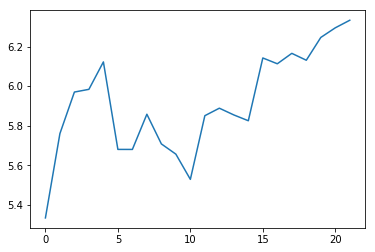

In [37]:
population_ratio = []

for i in tqdm_notebook(range(50)) :
    all_pairs = []
    for seq in np.vstack((population_f,reverse_population(population_b))):
        seq = seq[seq != -1][1:]
        for x in ngrams(seq,2):
            all_pairs.append(x)
            
    cp_1, cp_2, cp_3 = 0,0,0
    for p in all_pairs:
        if p in pairs_1:
            cp_1+=1
        elif p in pairs_2:
            cp_2+=1
        else:
            cp_3+=1

    population_ratio.append(cp_1 / cp_2)
    
    population_f, population_b = PCR_cycle(population_f, population_b, np.array([50,1]))

    if population_f.shape[0] > 20000:
        break

all_ratios_plots.append(population_ratio)

for p_r in all_ratios_plots:
    plt.plot(p_r)
plt.show()